## Steps:
- Generating captions for image
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
import cv2
import collections

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Read Text Caption 
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile("Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
captions[5]

'1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting'

In [4]:
# dictionary to map image to caption

In [5]:
descriptions = {}

for x in captions:
    first, second = x.split('\t')
    img_name = first.split('.')[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name] += [second]

descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

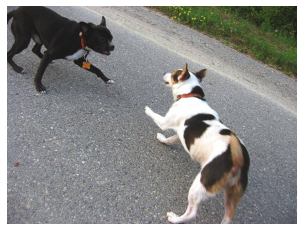

In [6]:
IMG_PATH = "Data/Images/"


img = cv2.imread(IMG_PATH+"1001773457_577c3a7d70.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

# Data cleaning

In [7]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ',sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [8]:
clean_text("A Rat Flys at 56Km/Hr for 4 days on day #7")

'rat flys at km hr for days on day'

In [9]:
# caption cleaning
for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tri colored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [10]:
# write to file
with open('descriptions.txt','w') as f:
    f.write(str(descriptions))


# Vocabulory creation

In [11]:
descriptions = None
with open('descriptions.txt','r') as f:
    descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tri colored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [12]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
len(vocab)

8424

In [13]:
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for dec in descriptions[key] for i in dec.split()]
len(total_words)

373837

In [14]:
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt))

8424


In [15]:
#sort by frequency count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])


threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]
len(total_words)

1845

# Prepare Train-Test Data

In [16]:
train_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [17]:
train = [row.split(".")[0] for row in train_file_data.split("\n")][:-1]
test = [row.split(".")[0] for row in test_file_data.split("\n")][:-1]


In [18]:
# prepare description for training data

train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = 'startseq ' + cap + ' endseq'
        train_descriptions[img_id].append(cap_to_append)

In [19]:
train_descriptions['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Transfer learning

## 1.) Image feature extraction

In [21]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]   